# Seismic data clusterization

In [2]:
!pip install segyio

In [2]:
import segyio
import matplotlib.pyplot as plt
import numpy as np

Trace(traces = 101, samples = 1001)
436.5027
203.77917


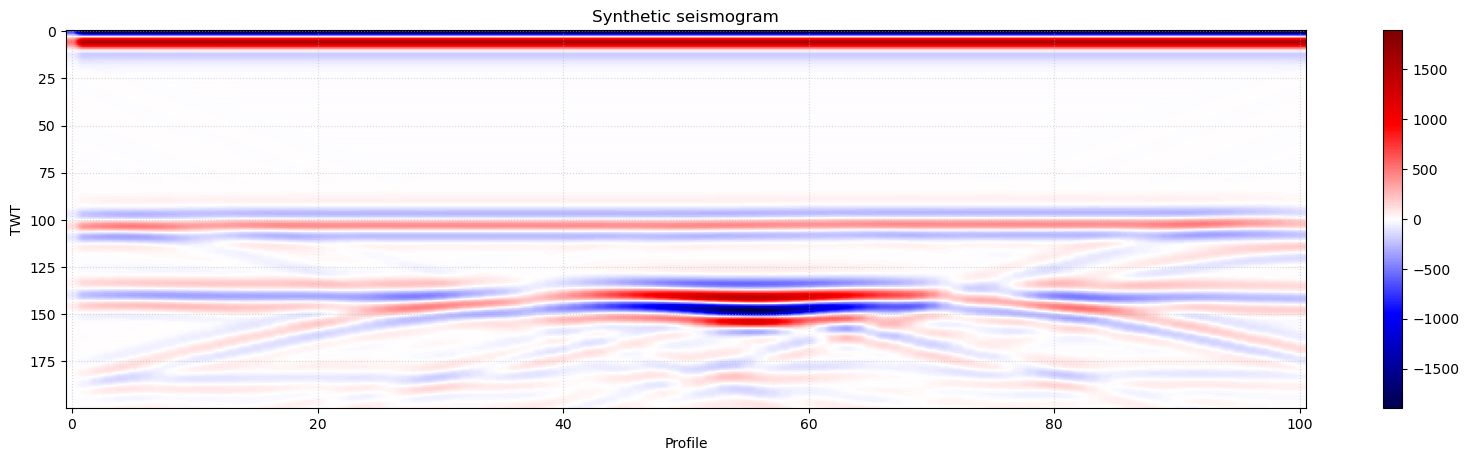

In [3]:
# Upload and visualization of seismic data


with segyio.open('Env1.sgy', mode='r+', iline=189, xline=171, strict=True, ignore_geometry=False, endian='big') as f:
    xsection = segyio.tools.collect(f.trace[:])
vminmax = np.max([np.abs(xsection[:, 50:200].min()),np.abs(xsection[:, 50:200].max())])

plt.figure(figsize=[20, 5], dpi=100)
plt.imshow(xsection[:, :200].transpose(), cmap='seismic', vmin=-vminmax, vmax=vminmax, aspect='auto')
plt.colorbar()
plt.title("Synthetic seismogram")
plt.grid(ls=':',alpha=.5)
plt.xlabel('Profile') 
plt.ylabel('TWT') 

Text(0, 0.5, 'Amplitude')

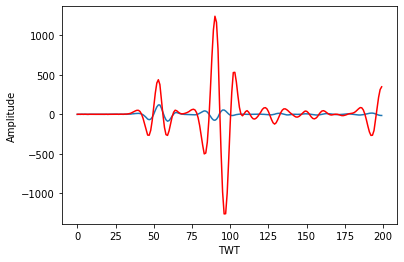

In [5]:
# Two traces comparison
plt.plot(xsection[0, 50:250], label = 'amplitude')
plt.plot(xsection[50, 50:250],  label = 'amplitude', c='red')
plt.xlabel('TWT')
plt.ylabel('Amplitude')

In [1]:
# DWT

!pip install dtw-python

DTW alignment object of size (query x reference): 50 x 50
Step pattern recursion:
 g[i,j] = min(
     g[i-3,j-2] +     d[i-2,j-1] +     d[i-1,j  ] +     d[i  ,j  ] ,
     g[i-1,j-1] +     d[i  ,j  ] ,
     g[i-2,j-3] +     d[i-1,j-2] +     d[i  ,j-1] + 0 * d[i  ,j  ] ,
 ) 

Normalization hint: N



<AxesSubplot:xlabel='Query index', ylabel='Reference index'>

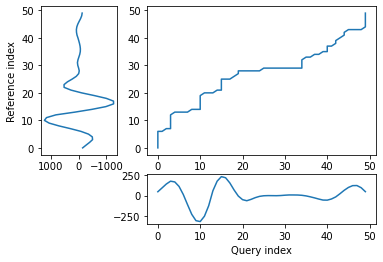

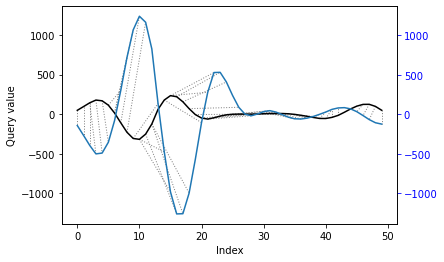

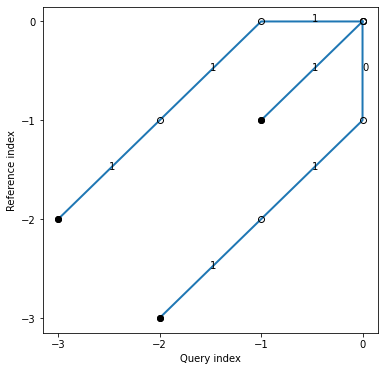

In [130]:
from dtw import *

# Calculating warping curve for each trace in relation to every other trace
# Getting arrays with indexes of samples
# Calculating euclidian distance between traces

# xsection - numpy array, containing seismic section

trace1_query = xsection[5, 130:180]
trace2_reference = xsection[50, 130:180]

alignment = dtw(trace1_query, trace2_reference, keep_internals=True)

## Display the warping curve, i.e. the alignment curve
alignment.plot(type="threeway")

## Align and plot with the Rabiner-Juang type VI-c unsmoothed recursion
dtw(trace1_query, trace2_reference, keep_internals=True, 
    step_pattern=rabinerJuangStepPattern(6, "c"))\
    .plot(type="twoway",offset=-2)

## See the recursion relation, as formula and diagram
print(rabinerJuangStepPattern(6,"c"))
rabinerJuangStepPattern(6,"c").plot()

In [131]:
# Clusterization of time sequences by Dynamic Time Warping (DTW)
# Solution -  https://www.kaggle.com/code/aavigan/time-series-clustering-with-dynamic-time-warping

from copy import deepcopy
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from copy import deepcopy
from scipy import signal



#
def warped_signal(path, warp_index, signal1):
    
    """the path array is an array of tuples of length 2 pairing indices from the two signals
    the warped index is the either 0 or 1 depending on which signal is desired to be warped. The
    values from the tuple correspond to the time indices of the warped signal
    """
    #create the warped_index and time_index arrays
    if warp_index == 0:
        
        warp_index = np.array(path)[:,0]
        time_index = np.array(path)[:,1]
    
    else:
        warp_index = np.array(path)[:,1]
        time_index = np.array(path)[:,0]

    #unique values of from the time_index array
    unique_time_index = np.unique(time_index)

    #instantiate warped_signal array
    warped_signal = np.zeros(len(unique_time_index))
    
    #create the time vector for the warped signal
    #time = time[unique_time_index]
    i =0
    
    #take the mean of warped signal values which share the same time_index
    for val in np.nditer(unique_time_index):
        indices = np.where(time_index == val)
        warped_signal[i] = np.mean(signal1[warp_index[tuple(indices)]])
        i += 1
    return unique_time_index, warped_signal



def tkeo_operator(data, k = 1):

    npnts = len(data[0])
    nsignals = len(data)
    filt_data = deepcopy(data)
    for i in range(nsignals):
        for n in range(k, npnts-k):
            filt_data[i][n] = data[i][n]**2-data[i][n-1]*data[i][n+1]      
    return filt_data

def standard_scaler(data):
    nsignals = len(data)
    for i in range(nsignals):
    #normalize to avoid spikes/plateaus during dtw due to differences in amplitudes
        normed_sig = (data[i]- np.mean(data[i]))/np.std(data[i])
        data[i] = normed_sig
    return data


def dtw_distance_matrix(data, window_size, indices):
    nsignals = len(data)
    dtw_dists = np.zeros([nsignals,nsignals])
    for i in range(nsignals):
        
        signal1 = data[i][indices[i][0]:indices[i][1]]
        for j in range(nsignals):
            signal2 = data[j][indices[j][0]:indices[j][1]]
            
            if i == j:
                dtw_dists[i,j] = 0
            
            if dtw_dists[i,j] == 0:
                cost_matrix, path, distance = pruned_dtw(signal1, signal2, window_size)
                
                dtw_dists[i,j] = distance
                dtw_dists[j,i] = distance
    return dtw_dists

#
def dtw_correlation(data, window_size, indices):
    nsignals = len(data)
    dtw_corrs = np.zeros([nsignals,nsignals])
    for i in range(nsignals):
        
        signal1 = data[i][indices[i][0]:indices[i][1]]
        for j in range(nsignals):
            signal2 = data[j][indices[j][0]:indices[j][1]]
            
            if i == j:
                dtw_corrs[i,j] = 1
            
            if dtw_corrs[i,j] == 0:
                # cost_matrix -
                # path - 
                # distance -
                cost_matrix, path, distance = pruned_dtw(signal1, signal2, window_size)

                #correlation between warped signal i and signal j
                index_w, warped_s = warped_signal(path, 0, signal1)
                corr = np.corrcoef(warped_s, signal2[(index_w)])[0,1]
                dtw_corrs[i,j] = corr

                #correlation between signal i and warped signal j
                index_w, warped_s = warped_signal(path, 1, signal2)
                corr = np.corrcoef(warped_s, signal1[(index_w)])[0,1]
                dtw_corrs[j,i] = corr
    return dtw_corrs

def pruned_dtw(matched, warped, window_size):
    #create distance matrix
    N = len(matched)
    M = len(warped)
    ub_coordinate_list, fraction, ub_partials = upper_bound_partials(matched, warped)
    ###
    #initialize auxiliary pruning variables
    start_column = 1 
    end_column = 1 
    
    #window must be greater than N-M
    window_size = np.max([window_size, N-M])

    #create cost matrix
    cost_matrix = np.ndarray((N+1, M+1))
    
    #initialize to infinity
    cost_matrix[:] = np.inf
   
    cost_matrix[0,0] = 0
    ###
    UB = ub_partials[1]
    ###
    #create traceback matrix
    traceback_matrix = np.ones((N,M))*np.inf
    
    #initialize window elements to zero
    for i in range(1,N+1):

        if N>=M:
            ub_col_index = int(np.floor(i*fraction))
            
        else:
            ub_col_index = int(np.floor(i/fraction))
        
        
        beg = np.max([start_column,ub_col_index-window_size])
        end = np.min([M+1, ub_col_index+window_size+1])
        smaller_found = False
        end_column_next = ub_col_index
        
        for j in range(beg, end):
            cost = np.abs(matched[i-1]-warped[j-1])
            # Defining minimal losses accoriding to steps in different direction
            penalty = [cost_matrix[i-1,j-1],  #match 0
                       cost_matrix[i-1,j], # insertion 1
                       cost_matrix[i, j-1]] # deletion 2
            penalty_index = np.argmin(penalty)
            
            traceback_matrix[i-1,j-1] = penalty_index
            cost_matrix[i,j] = cost + penalty[penalty_index]
            
            ###
            #if i == ub_col_index and i != N:
            
            if (i,j) in ub_coordinate_list:
                ub_index = ub_coordinate_list.index((i,j))
                # Summation of cumulative difference and cost of step
                UB = cost_matrix[i,j] + ub_partials[ub_index]
            
            ##pruning algorithm
            # If cumulative difference isn't zero
            if cost_matrix[i,j] > UB:
                # No better way
                if smaller_found == False:
                    start_column = j+1
                
                if j >= end_column:
                    break
            # If cumulative difference is zero
            else:
                smaller_found = True
                end_column_next = j+1
        end_column = end_column_next
        
    #traceback from bottom right corner
    
    i = N-1
    j = M-1
    
    path = [(i, j)]
    
    while i>0 and j>0:
        
        tb_type = traceback_matrix[i,j]
        
        if tb_type == 0: 
            #match
            i = i-1
            j= j-1
        
        elif tb_type == 1:
            #insertion
            i = i-1
        else:
            #deletion
            j = j-1
        
        path.append((i,j))
    
    #strip infinite row and column from cost matrix
    cost_matrix = cost_matrix[1:, 1:]
    
    distance = cost_matrix[-1,-1]
    #invert path
    path= path[::-1]
    
    return cost_matrix, path, distance


def upper_bound_partials(signal1, signal2):
    signal_list = [signal1, signal2]
    coordinate_list = [[],[]]
    # Arrays of signal lengths 
    signal_lengths = [len(x) for x in signal_list]
    
    # If signals' lengths aren't same
    if signal_lengths[0]!= signal_lengths[1]:
        index_long = np.argmax(signal_lengths)
        index_short = np.argmin(signal_lengths)
        # Length of long signal
        long_len = len(signal_list[index_long])
        # Length of short signal
        short_len = len(signal_list[index_short])
        # Length relation
        fraction = short_len/long_len
        # Array of long signal samples' indexes 
        long_index_list = [i for i in range(long_len)]
        # Array, there each index of long signal multiplied by length relation and rounded to lower number
        # Indexes of short signal "streches up" to long signal 
        short_index_list = [int(np.floor(x*fraction)) for x in range(long_len)]
        # Stretched short signal
        warped_short = np.take(signal_list[index_short], short_index_list)
        # Mirrored array of difference between two signals
        ub_partials = np.abs(signal_list[index_long]-warped_short)[::-1]
        
        # Coordinates - indexes of signals' samples
        coordinate_list[index_long] = long_index_list
        coordinate_list[index_short] = short_index_list
    # If signals' lengths aren't same    
    else:
        # Mirrored array of difference between two signals
        ub_partials = np.abs(signal_list[0]-signal_list[1])[::-1]
        fraction = 1
        index_list1 = [i for i in range(signal_lengths[0])]
        index_list2 = [i for i in range(signal_lengths[1])]
        coordinate_list[0] = index_list1
        coordinate_list[1] = index_list2
    # Cumulative sum of difference in each sample, mirrored
    ub_partials = np.cumsum(ub_partials)[::-1]
    # Array of pairs related to each other according to indexes' length of array
    coordinate_list = zip(coordinate_list[0],coordinate_list[1])
    return list(coordinate_list), fraction, ub_partials 


# Moving average deviation
def rolling_std(signal1, k):
    n = len(signal1)
    window_size = 2*k+1
    std_ts = np.zeros(n)
    for ti in range(n):
        low_bnd = np.max([0, ti-k])
        up_bnd = np.min([n,ti+k])
        tmp_sig = signal1[low_bnd:up_bnd]
        std_ts[ti] = np.std(tmp_sig)

    return std_ts


# Function deletes white noise from trace, it returnes start and end index of trace's sample. Cutting out most intensive 
# part
def segment_indices(signal1, thresh =.9, k = 10, pad = 10):
    halfwin = k
    std_ts = rolling_std(signal1, halfwin)
    n = len(signal1)
    indices = np.where(std_ts>thresh)[0][[0,-1]]
    indices[0] = max([indices[0]-pad, 0])
    indices[1] = min([indices[1]+pad, n]) 
    return indices


# Fuction creates array of signals' parts indexes for whole seismogram 
def segment_data(data, thresh = .9, k =10, pad = 10):
    nsignals = len(data)
    indices = np.zeros([nsignals,2],dtype = int)
    for i in range(nsignals):
        ind = segment_indices(data[i], thresh = thresh, k = k, pad = pad)
        indices[i] = ind    
    return indices


# Function visualize clusters by T-distributed Stochastic Neihbor Embedding method
def tsne_visualization(dtw_dists, centroids, data_labels):
    model = TSNE(learning_rate = 20, perplexity = 3)
    nsignals = len(dtw_dists)
    transformed = model.fit_transform(np.concatenate([dtw_dists, centroids]))
    
    xs = transformed[:,0]
    ys = transformed[:,1]

    plt.scatter(xs,ys, marker = 's')
    plt.scatter(xs[nsignals:],ys[nsignals:], marker = 'p', label = 'centroids')  
     
    plt.title('TSNE of DTW correlation matrix')
    plt.show()

In [132]:
# 1.  There are Seismogramm | part of seismogramm (xsection), index indent (pad), threshold dispertion (thresh), wide of window (k)
# for moving dispersing in the input. There is array of segments pairs, enhancing signal in the output.

indxs = segment_data(xsection[:, 130:160], pad = 10, thresh = 1, k=10)


# 2. There are seismogram / part of seismogram, indexes from the previous step, window width in the input. 
#  There is correlation matrix between seismic traces in the output. 
dtw_dists = dtw_correlation(data = xsection[:, 130:160], window_size = 10, indices = indxs)

# 3. Creating of class Kmeans instance 

kmeans_model = KMeans(n_clusters = 2)

# 4. fit_predict - method of Kmeans class calculates centres of clusters and define which cluster each sample belongs

clusters = kmeans_model.fit_predict(dtw_dists)

print(clusters)





[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0
 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0
 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


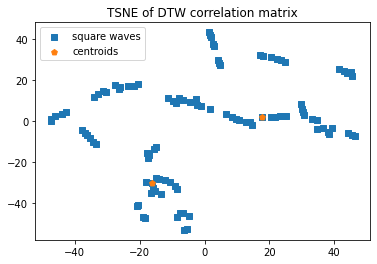

In [133]:

data_labels = np.array(['1', '2'])

tsne_visualization(dtw_dists, kmeans_model.cluster_centers_, data_labels = np.array(['1', '2']))

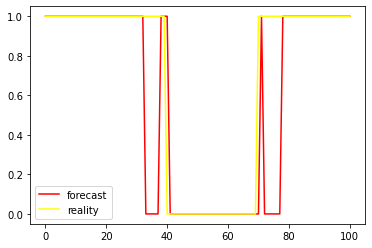

In [140]:
# Forecat of Lateral distribution reservoir (1) / not-reservoir (0)Распределение коллектор (1)
# And reality

real_lateral = np.zeros(101)

for t in range(0, 40):
    real_lateral[t] = 1
    
for t in range(40, 70):
    real_lateral[t] = 0
    
for t in range(70, 101): 
    real_lateral[t] = 1
    
    
lateral = np.arange(101)

plt.plot(lateral, clusters,  label = 'forecast', c='red')
plt.plot(lateral, real_lateral,  label = 'reality', c='yellow')
plt.legend()

